In [17]:
import os
from six import string_types
import numpy as np
import pandas as pd
from skimage import io
from glob import glob
from tqdm import tqdm
import cv2

from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

%matplotlib inline


In [6]:
PLANET_KAGGLE_ROOT = os.path.abspath("../data/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_JPEG_DIR_TEST = os.path.join(PLANET_KAGGLE_ROOT, 'test-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR_TEST)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [7]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)

# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [8]:
# Preprocess labels
label_map = {l: i for i, l in enumerate(label_list)}

# Prepare array of labels
y_train = []

for f, tags in tqdm(labels_df.values, miniters=1000):
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    y_train.append(targets)

y_train = np.array(y_train, np.uint8)

100%|██████████| 40479/40479 [00:00<00:00, 194101.80it/s]


In [5]:
# Print all unique classes
print(label_map)

{'haze': 0, 'primary': 1, 'agriculture': 2, 'clear': 3, 'water': 4, 'habitation': 5, 'road': 6, 'cultivation': 7, 'slash_burn': 8, 'cloudy': 9, 'partly_cloudy': 10, 'conventional_mine': 11, 'bare_ground': 12, 'artisinal_mine': 13, 'blooming': 14, 'selective_logging': 15, 'blow_down': 16}


In [6]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  
0         0                  0          0  
1         0                  0          0  
2         0                  0          0  
3         0                  0          0  
4         0                  0          0

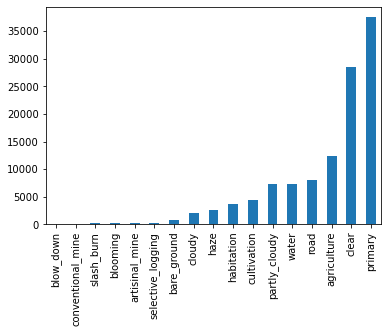

In [7]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

In [8]:
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [9]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            ##########print('Found image {}'.format(path))
            return io.imread(path)
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))
    
def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.at[sample_df.index[row_idx], 'image_name']
    return '{}.{}'.format(fname, suffix)

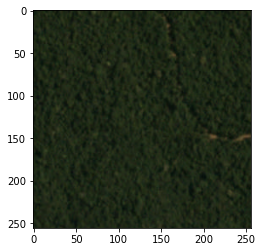

In [10]:
sampled_images = sample_images(['clear', 'road', 'water'], n=1)

for i in range(len(sampled_images)):
    jpg = sample_to_fname(sampled_images, i, 'jpg')

    try:
        jpg_img = load_image(jpg)[:,:,:3]

        fig = plt.figure()
        fig.set_size_inches(4, 4)
        plt.imshow(jpg_img)
    except:
        continue

### Embeddings

In [11]:
#FEATURES_KAGGLE = os.path.abspath("../data/features/Kaggle")

#features_bigearthnet = np.load(os.path.join(FEATURES_KAGGLE, 'features_bigearthnet_Kaggle.npy'))
#features_EuroSAT = np.load(os.path.join(FEATURES_KAGGLE, 'features_EuroSAT_Kaggle.npy'))
#features_ResNet50 = np.load(os.path.join(FEATURES_KAGGLE, 'features_ImageNet-ResNet50_Kaggle.npy'))
#features_Resic45 = np.load(os.path.join(FEATURES_KAGGLE, 'features_Resic45_Kaggle.npy'))
#features_So2Sat = np.load(os.path.join(FEATURES_KAGGLE, 'features_So2Sat_Kaggle.npy'))
#features_Tile2Vec = np.load(os.path.join(FEATURES_KAGGLE, 'features_Tile2Vec_Kaggle.npy'))
#features_UCMerced = np.load(os.path.join(FEATURES_KAGGLE, 'features_UC_Merced_Kaggle.npy'))
#features_InceptionV3 = np.load(os.path.join(FEATURES_KAGGLE, 'features_InceptionV3_pool_Kaggle.npy'))

### t-SNE

In [12]:
#print(features_bigearthnet.shape)
#tsne_bigearthnet = TSNE(
#    n_components=2,
#    init='random', # pca
#    random_state=101,
#    method='barnes_hut',
#    n_iter=500,
#    verbose=2
#).fit_transform(features_bigearthnet)

In [15]:
TSNE_KAGGLE = os.path.abspath("../data/features/Kaggle/TSNE")

tsne_bigearthnet = np.load(os.path.join(TSNE_KAGGLE, 'tsne_bigearthnet.npy'))
tsne_EuroSAT = np.load(os.path.join(TSNE_KAGGLE, 'tsne_EuroSAT.npy'))
tsne_ResNet50 = np.load(os.path.join(TSNE_KAGGLE, 'tsne_ResNet50.npy'))
tsne_Resic45 = np.load(os.path.join(TSNE_KAGGLE, 'tsne_Resic45.npy'))
tsne_So2Sat = np.load(os.path.join(TSNE_KAGGLE, 'tsne_So2Sat.npy'))
tsne_Tile2Vec = np.load(os.path.join(TSNE_KAGGLE, 'tsne_Tile2Vec.npy'))
tsne_UCMerced = np.load(os.path.join(TSNE_KAGGLE, 'tsne_UCMerced.npy'))
tsne_InceptionV3 = np.load(os.path.join(TSNE_KAGGLE, 'tsne_InceptionV3.npy'))
tsne_CannyEdgeSpace = np.load(os.path.join(TSNE_KAGGLE, 'tsne_CannyEdgeSpace.npy'))
tsne_MeanColorSpace = np.load(os.path.join(TSNE_KAGGLE, 'tsne_MeanColorSpace.npy'))

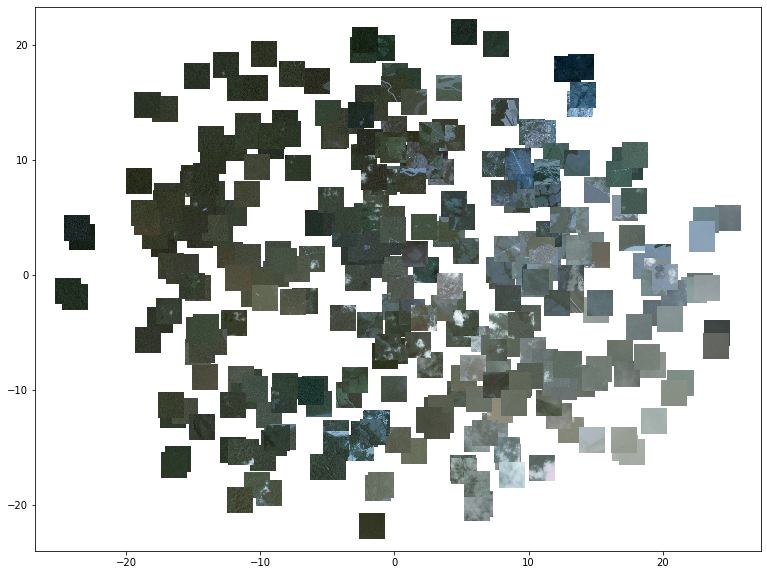

In [19]:
# Plot the subset of images in a two dimensional representation
n_imgs = 350

def imscatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(tsne_bigearthnet[0:n_imgs,0], tsne_bigearthnet[0:n_imgs,1], [cv2.imread('../data/train-jpg/train_{}.jpg'.format(i)) for i in range(n_imgs)])


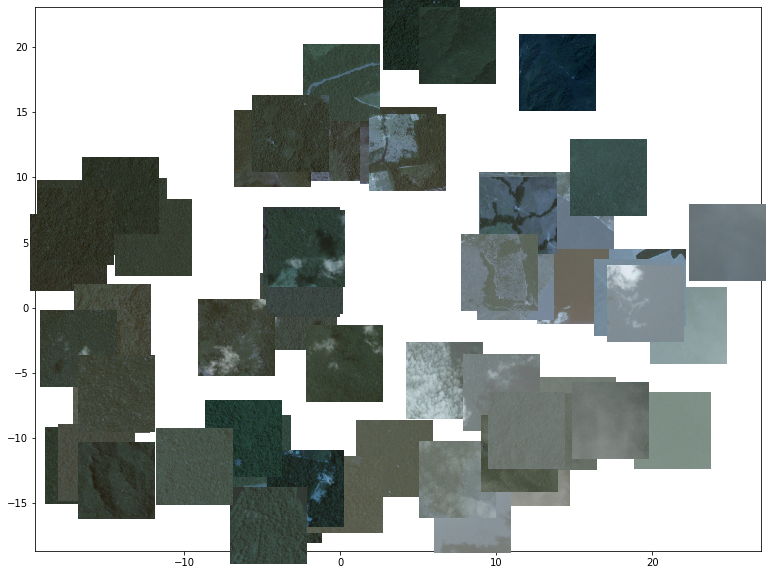

In [20]:
# Subset of images for clustering
n_imgs = 60
offset = 100

# Plot the subset of images in a two dimensional representation
def imscatter(x, y, images, ax=None, zoom=0.3):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(tsne_bigearthnet[offset:offset + n_imgs, 0], tsne_bigearthnet[offset:offset + n_imgs, 1], [cv2.imread('../data/train-jpg/train_{}.jpg'.format(offset + i)) for i in range(n_imgs)])

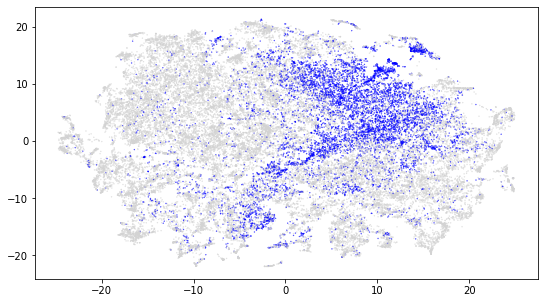

In [16]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_bigearthnet[:, 0], tsne_bigearthnet[:, 1], c=color, s=0.1, cmap='Scatter');

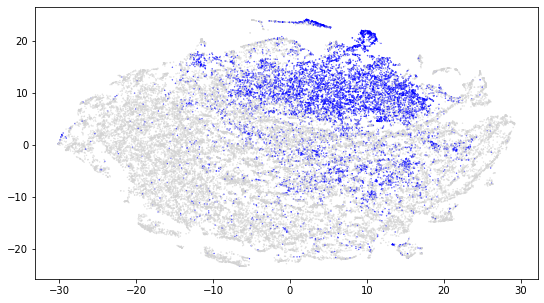

In [17]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_EuroSAT[:, 0], tsne_EuroSAT[:, 1], c=color, s=0.1, cmap='Scatter');

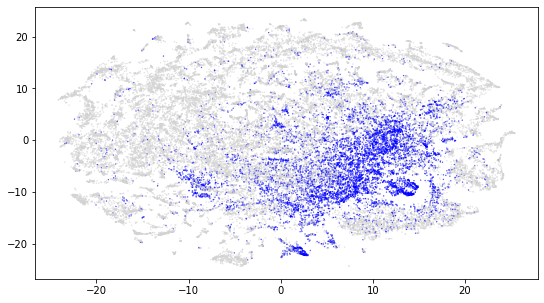

In [18]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_ResNet50[:, 0], tsne_ResNet50[:, 1], c=color, s=0.1, cmap='Scatter');

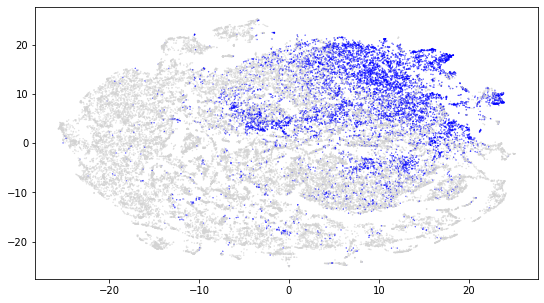

In [19]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_Resic45[:, 0], tsne_Resic45[:, 1], c=color, s=0.1, cmap='Scatter');

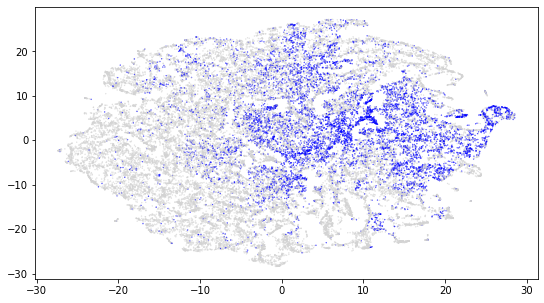

In [20]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_So2Sat[:, 0], tsne_So2Sat[:, 1], c=color, s=0.1, cmap='Scatter');

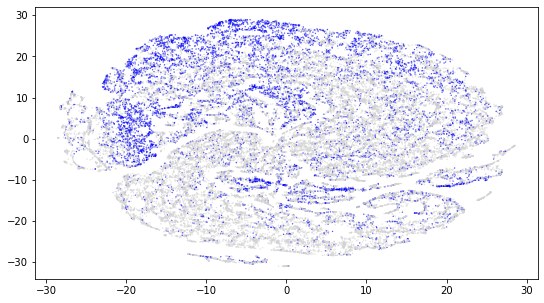

In [21]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_Tile2Vec[:, 0], tsne_Tile2Vec[:, 1], c=color, s=0.1, cmap='Scatter');

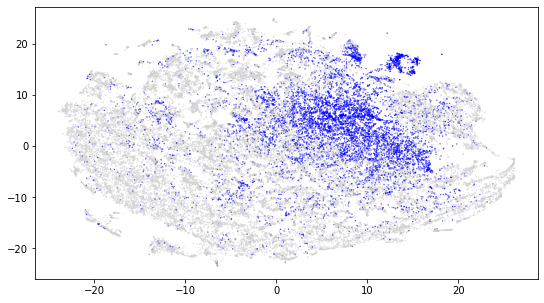

In [22]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_UCMerced[:, 0], tsne_UCMerced[:, 1], c=color, s=0.1, cmap='Scatter');

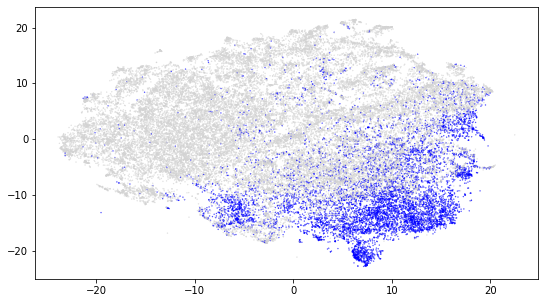

In [23]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_InceptionV3[:, 0], tsne_InceptionV3[:, 1], c=color, s=0.1, cmap='Scatter');

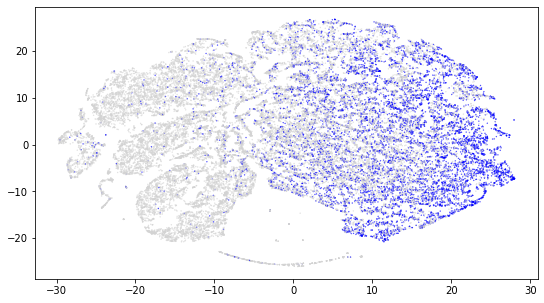

In [24]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_CannyEdgeSpace[:, 0], tsne_CannyEdgeSpace[:, 1], c=color, s=0.1, cmap='Scatter');

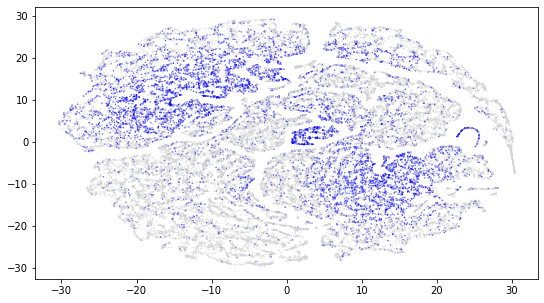

In [25]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_MeanColorSpace[:, 0], tsne_MeanColorSpace[:, 1], c=color, s=0.1, cmap='Scatter');

##### Weather

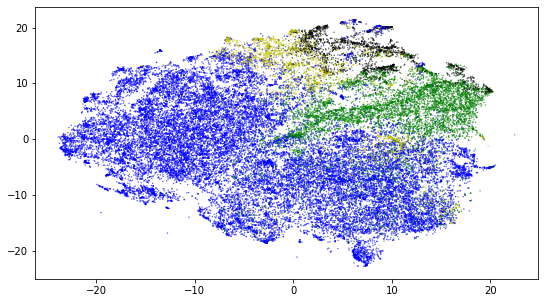

In [26]:
color = []
for i in range(len(y_train)):
    if y_train[i,0] == 1: #haze
        color.append('y')
    elif y_train[i,3] == 1: #clear
        color.append('b')
    elif y_train[i,9] == 1: #cloudy
        color.append('k')
    else: #partly cloudy
        color.append('g')
        
plt.figure(figsize=(9,5))
plt.scatter(tsne_InceptionV3[:, 0], tsne_InceptionV3[:, 1], c=color, s=0.1, cmap='Spectral');

### PCA

In [27]:
#pca_bigearthnet = PCA(n_components=2).fit_transform(features_bigearthnet)

In [28]:
PCA_KAGGLE = os.path.abspath("../data/features/Kaggle/PCA")

pca_bigearthnet = np.load(os.path.join(PCA_KAGGLE, 'pca_bigearthnet.npy'))
pca_EuroSAT = np.load(os.path.join(PCA_KAGGLE, 'pca_EuroSAT.npy'))
pca_ResNet50 = np.load(os.path.join(PCA_KAGGLE, 'pca_ResNet50.npy'))
pca_Resic45 = np.load(os.path.join(PCA_KAGGLE, 'pca_Resic45.npy'))
pca_So2Sat = np.load(os.path.join(PCA_KAGGLE, 'pca_So2Sat.npy'))
pca_Tile2Vec = np.load(os.path.join(PCA_KAGGLE, 'pca_Tile2Vec.npy'))
pca_UCMerced = np.load(os.path.join(PCA_KAGGLE, 'pca_UCMerced.npy'))
pca_InceptionV3 = np.load(os.path.join(PCA_KAGGLE, 'pca_InceptionV3.npy'))
pca_CannyEdgeSpace = np.load(os.path.join(PCA_KAGGLE, 'pca_CannyEdgeSpace.npy'))
pca_MeanColorSpace = np.load(os.path.join(PCA_KAGGLE, 'pca_MeanColorSpace.npy'))

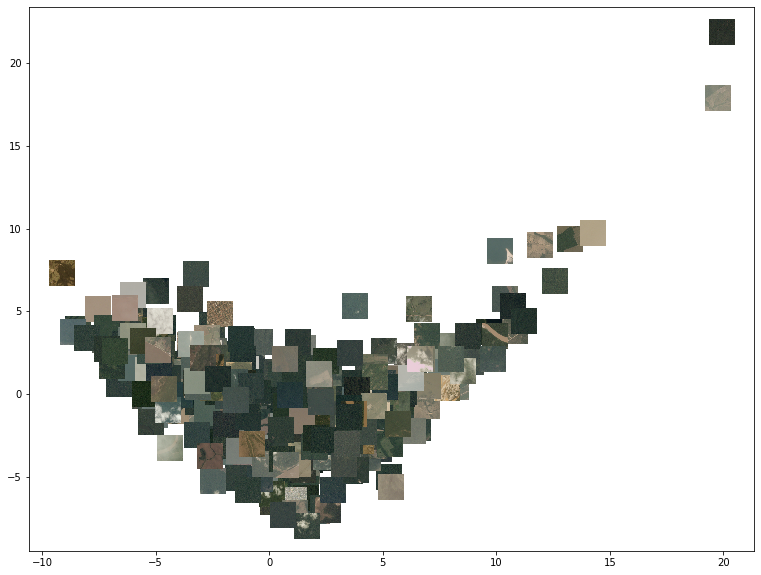

In [29]:
# Plot the subset of images in a two dimensional representation
n_imgs = 350

def imscatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(pca_bigearthnet[0:n_imgs,0], pca_bigearthnet[0:n_imgs,1], [cv2.imread('../data/train-jpg/train_{}.jpg'.format(i)) for i in range(n_imgs)])

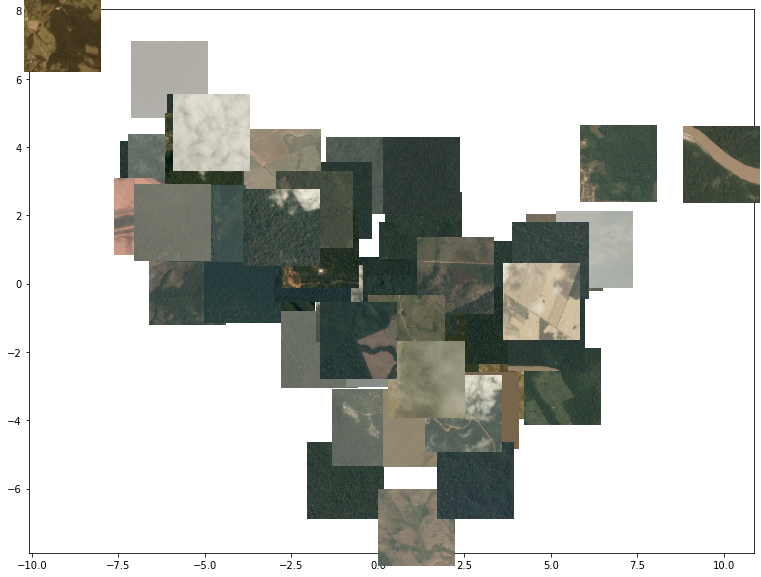

In [30]:
# Subset of images for clustering
n_imgs = 60
offset = 200
image_paths = sorted(glob('../data/train-jpg/*.jpg'))[0:offset + n_imgs]


# Plot the subset of images in a two dimensional representation
def imscatter(x, y, images, ax=None, zoom=0.3):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(pca_bigearthnet[offset:offset + n_imgs, 0], pca_bigearthnet[offset:offset + n_imgs, 1], [plt.imread(image_paths[offset + i]) for i in range(n_imgs)])

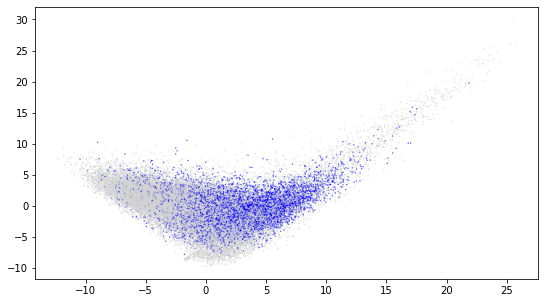

In [31]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_bigearthnet[:, 0], pca_bigearthnet[:, 1], c=color, s=0.1, cmap='Scatter');

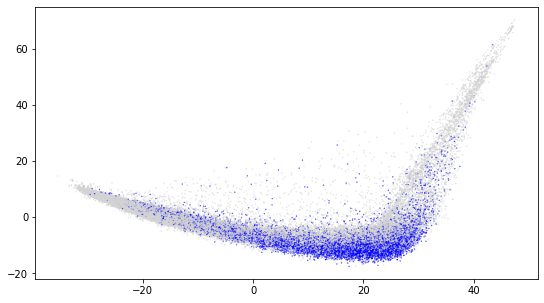

In [32]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_EuroSAT[:, 0], pca_EuroSAT[:, 1], c=color, s=0.1, cmap='Scatter');

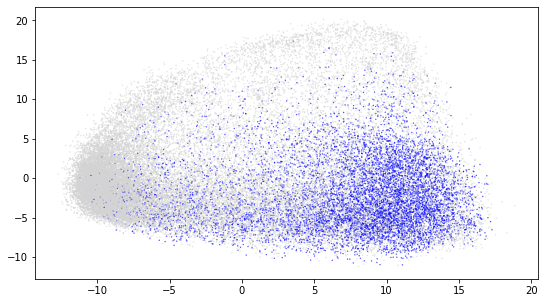

In [33]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_ResNet50[:, 0], pca_ResNet50[:, 1], c=color, s=0.1, cmap='Scatter');

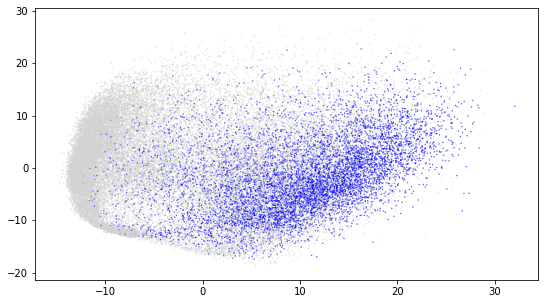

In [34]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_Resic45[:, 0], pca_Resic45[:, 1], c=color, s=0.1, cmap='Scatter');

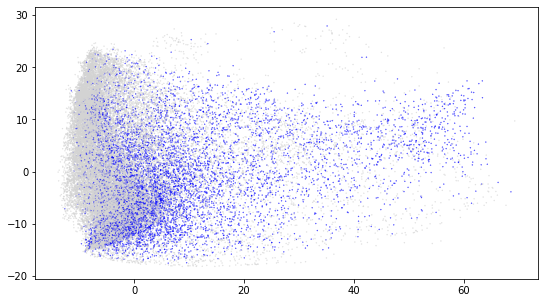

In [35]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_So2Sat[:, 0], pca_So2Sat[:, 1], c=color, s=0.1, cmap='Scatter');

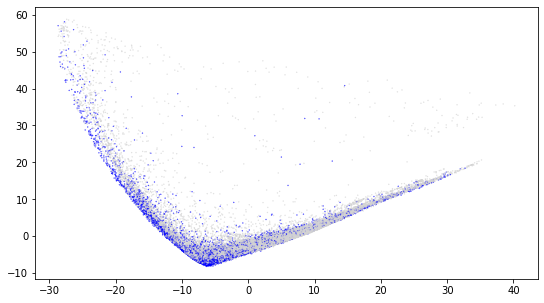

In [36]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_Tile2Vec[:, 0], pca_Tile2Vec[:, 1], c=color, s=0.1, cmap='Scatter');

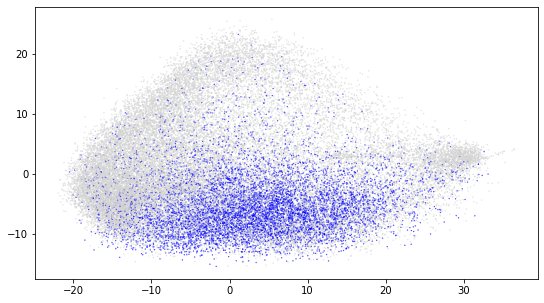

In [37]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_UCMerced[:, 0], pca_UCMerced[:, 1], c=color, s=0.1, cmap='Scatter');

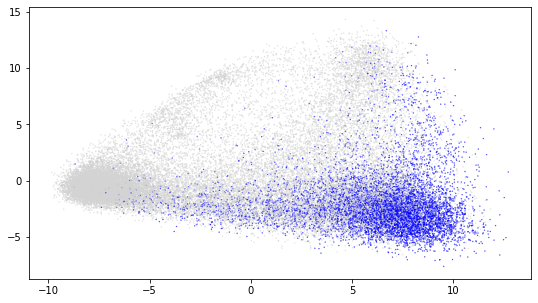

In [38]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_InceptionV3[:, 0], pca_InceptionV3[:, 1], c=color, s=0.1, cmap='Scatter');

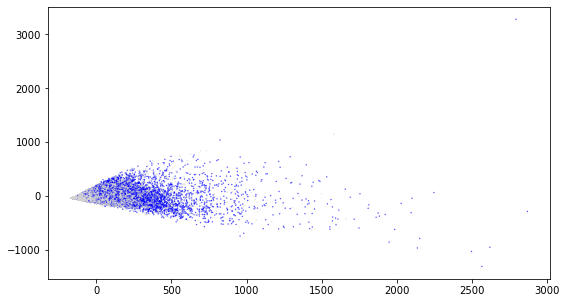

In [39]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_CannyEdgeSpace[:, 0], pca_CannyEdgeSpace[:, 1], c=color, s=0.1, cmap='Scatter');

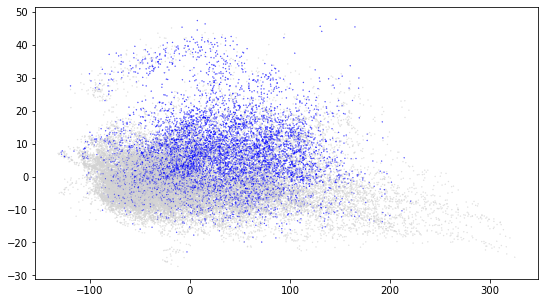

In [40]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_MeanColorSpace[:, 0], pca_MeanColorSpace[:, 1], c=color, s=0.1, cmap='Scatter');

##### Weather

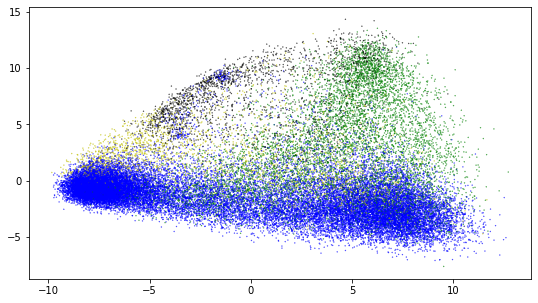

In [41]:
color = []
for i in range(len(y_train)):
    if y_train[i,0] == 1: #haze
        color.append('y')
    elif y_train[i,3] == 1: #clear
        color.append('b')
    elif y_train[i,9] == 1: #cloudy
        color.append('k')
    else: #partly cloudy
        color.append('g')
        
plt.figure(figsize=(9,5))
plt.scatter(pca_InceptionV3[:, 0], pca_InceptionV3[:, 1], c=color, s=0.1, cmap='Spectral');

### UMAP

In [42]:
#umap_bigearthnet = umap.UMAP(
#    n_neighbors=100,
#    min_dist=0.0,
#    n_components=2,
#    random_state=42,
#).fit_transform(features_bigearthnet)

In [22]:
UMAP_KAGGLE = os.path.abspath("../data/features/Kaggle/UMAP")

umap_bigearthnet = np.load(os.path.join(UMAP_KAGGLE, 'umap_bigearthnet.npy'))
umap_EuroSAT = np.load(os.path.join(UMAP_KAGGLE, 'umap_EuroSAT.npy'))
umap_ResNet50 = np.load(os.path.join(UMAP_KAGGLE, 'umap_ResNet50.npy'))
umap_Resic45 = np.load(os.path.join(UMAP_KAGGLE, 'umap_Resic45.npy'))
umap_So2Sat = np.load(os.path.join(UMAP_KAGGLE, 'umap_So2Sat.npy'))
umap_Tile2Vec = np.load(os.path.join(UMAP_KAGGLE, 'umap_Tile2Vec.npy'))
umap_UCMerced = np.load(os.path.join(UMAP_KAGGLE, 'umap_UCMerced.npy'))
umap_InceptionV3 = np.load(os.path.join(UMAP_KAGGLE, 'umap_InceptionV3.npy'))
umap_CannyEdgeSpace = np.load(os.path.join(UMAP_KAGGLE, 'umap_CannyEdgeSpace.npy'))
umap_MeanColorSpace = np.load(os.path.join(UMAP_KAGGLE, 'umap_MeanColorSpace.npy'))

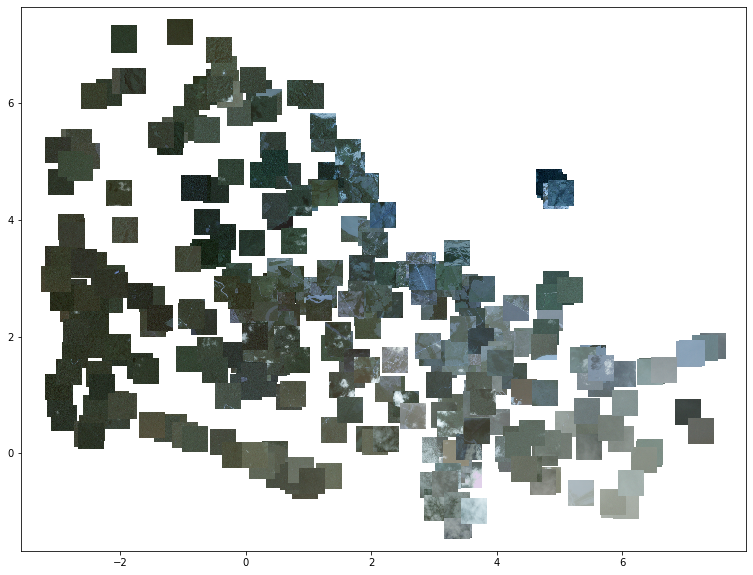

In [24]:
# Plot the subset of images in a two dimensional representation
n_imgs = 350

def imscatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(umap_bigearthnet[0:n_imgs,0], umap_bigearthnet[0:n_imgs,1], [cv2.imread('../data/train-jpg/train_{}.jpg'.format(i)) for i in range(n_imgs)])

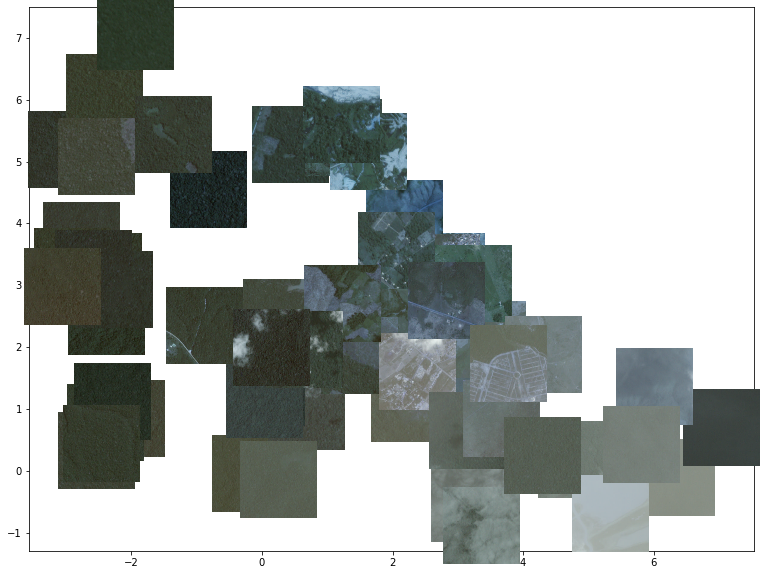

In [25]:
# Subset of images for clustering
n_imgs = 60
offset = 200

# Plot the subset of images in a two dimensional representation
def imscatter(x, y, images, ax=None, zoom=0.3):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(umap_bigearthnet[offset:offset + n_imgs, 0], umap_bigearthnet[offset:offset + n_imgs, 1], [cv2.imread('../data/train-jpg/train_{}.jpg'.format(offset + i)) for i in range(n_imgs)])

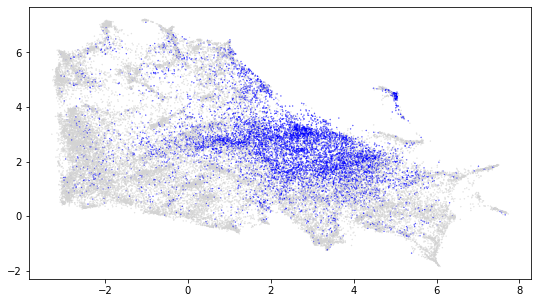

In [46]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_bigearthnet[:, 0], umap_bigearthnet[:, 1], c=color, s=0.1, cmap='Scatter');

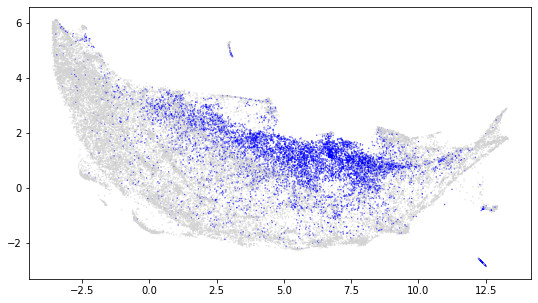

In [47]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_EuroSAT[:, 0], umap_EuroSAT[:, 1], c=color, s=0.1, cmap='Scatter');

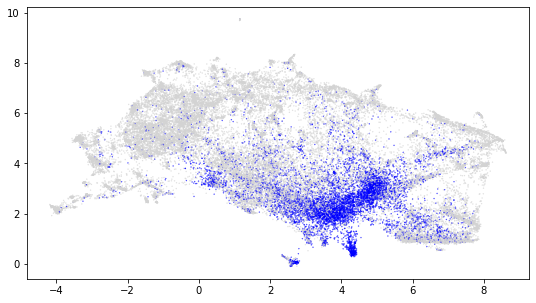

In [48]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_ResNet50[:, 0], umap_ResNet50[:, 1], c=color, s=0.1, cmap='Scatter');

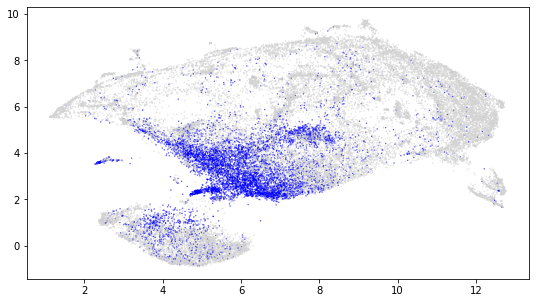

In [49]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_Resic45[:, 0], umap_Resic45[:, 1], c=color, s=0.1, cmap='Scatter');

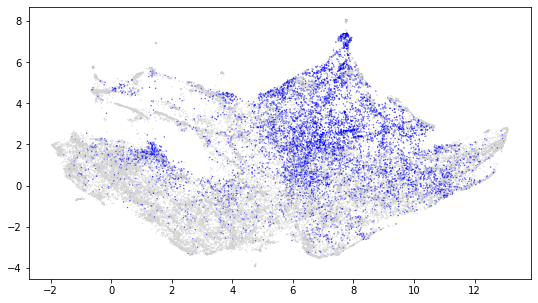

In [50]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_So2Sat[:, 0], umap_So2Sat[:, 1], c=color, s=0.1, cmap='Scatter');

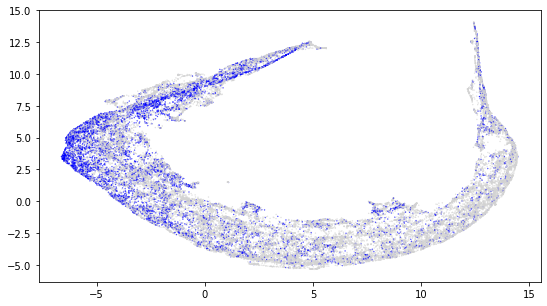

In [51]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_Tile2Vec[:, 0], umap_Tile2Vec[:, 1], c=color, s=0.1, cmap='Scatter');

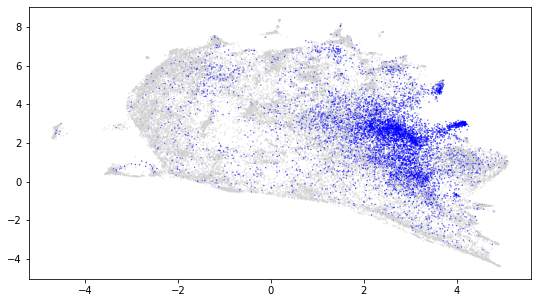

In [52]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_UCMerced[:, 0], umap_UCMerced[:, 1], c=color, s=0.1, cmap='Scatter');

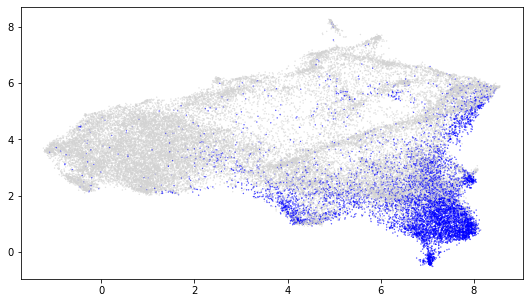

In [53]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_InceptionV3[:, 0], umap_InceptionV3[:, 1], c=color, s=0.1, cmap='Scatter');

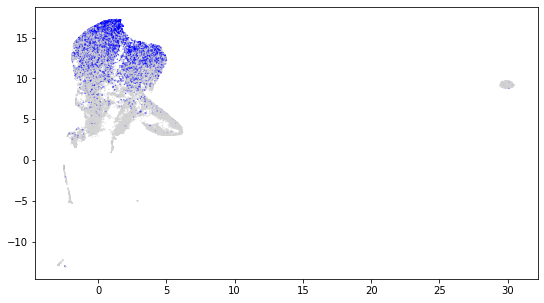

In [54]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_CannyEdgeSpace[:, 0], umap_CannyEdgeSpace[:, 1], c=color, s=0.1, cmap='Scatter');

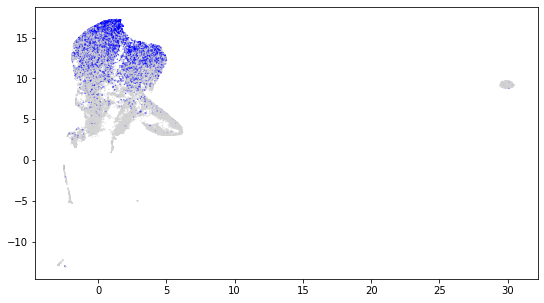

In [55]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_CannyEdgeSpace[:, 0], umap_CannyEdgeSpace[:, 1], c=color, s=0.1, cmap='Scatter');

##### Weather

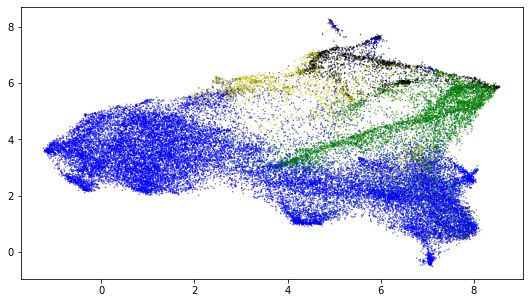

In [56]:
color = []
for i in range(len(y_train)):
    if y_train[i,0] == 1: #haze
        color.append('y')
    elif y_train[i,3] == 1: #clear
        color.append('b')
    elif y_train[i,9] == 1: #cloudy
        color.append('k')
    else: #partly cloudy
        color.append('g')
        
plt.figure(figsize=(9,5))
plt.scatter(umap_InceptionV3[:, 0], umap_InceptionV3[:, 1], c=color, s=0.1, cmap='Spectral');

## Accuracies

In [87]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def evaluate_LF(LF, df, tag, n=1000, full_dataset = False, print_evaluation=True):
    #print(namestr(LF, globals()))
    
    if full_dataset:
        n = df.shape[0]
    
    # Sample n images from the dataset
    sampled_images = df[:].sample(n)

    # Evaluate
    tp, fp, tn, fn = 0, 0, 0, 0
    abst = 0
    for index, row in sampled_images.iterrows():
        pred = LF(row)
        if pred == 1: 
            if row[tag] == 1:
                tp += 1
            else:
                fp += 1
        elif pred == 0:
            if row[tag] == 0:
                tn += 1
            else:
                fn += 1
        else:
            abst += 1  

    # Calculate the accuracy of LF
    accuracy = (tp + tn)/(tp + fp + tn + fn)
    precision = tp / (tp + fp)
    coverage = (n - abst) / n
    
    if print_evaluation:
        print('TP: ', tp)
        print('FP: ', fp)
        print('TN: ', tn)
        print('FN: ', fn)
        print('abstain: ', abst)
        print('accuracy: ', accuracy)
        print('precision: ', precision)
        print('coverage: ', coverage)
        
    return

In [88]:
# Splits of the original Kaggle dataset for training, validation and testing
SPLIT_TRAIN = 10000
SPLIT_VALIDATE = 12000

In [89]:
# Define label mappings for Snorkle voting for convenience
NEGATIVE = 0
POSITIVE = 1
ABSTAIN = -1

In [90]:
# Define category mappings within labels_df for convenience
HAZE_MAP = 0
PRIMARY_MAP = 1
AGRICULTURE_MAP = 2
CLEAR_MAP = 3
WATER_MAP = 4
HABITATION_MAP = 5
ROAD_MAP = 6
CLOUDY_MAP = 9
PARTLY_CLOUDY_MAP = 10 

In [91]:
labels_df_train = labels_df.iloc[:SPLIT_TRAIN]
labels_df_valid = labels_df.iloc[SPLIT_TRAIN:SPLIT_VALIDATE]
labels_df_test = labels_df.iloc[SPLIT_VALIDATE:]

### UMAP

In [234]:
# Set polygons within UMAP embedding to cluster/label data for following labels:
# 0 - haze
# 1 - primary
# 2 - agriculture
# 3 - clear
# 4 - water
# 5 - habitation
# 6 - road
# 9 - cloudy
# 10 - partly_cloudy

# TBD: more precise polygons/bounding boxes including abstaining regions

from shapely.geometry import Point, Polygon

umap_bigearthnet_coords = [[] for i in range(17)]
umap_bigearthnet_coords[0] = [(4, -0.7), (4, 1.0), (6.2, 1.0), (6.2, -0.7)]
umap_bigearthnet_coords[1] = [(-4, -0.7), (-4, 7.5), (5.4, 7.5), (5.4, -0.7)]
umap_bigearthnet_coords[2] = [(0.3, 0.6), (0.3, 4), (5, 4), (5, 0.6)]
#umap_bigearthnet_coords[3] = [(-6, -6), (-6, 6), (7, 6), (7, 0.9), (14, 0.9), (14, -6)] #TBD
umap_bigearthnet_coords[4] = [(-1, 0.7), (-1, 3.7), (5, 3.7), (5, 0.7)]
#umap_bigearthnet_coords[5] = [(8, -5.5), (8, -3.2), (11.5, -3.2), (11.5, -5.5)] #TBD
#umap_bigearthnet_coords[6] = [(8, -5.4), (8, 1.9), (11.5, 1.9), (11.5, -5.4)] #TBD
#umap_bigearthnet_coords[9] = [(8.7, 6), (8.7, 11), (12.2, 11), (12.2, 6)] #TBD
#umap_bigearthnet_coords[10] = [(5, 1.5), (5, 4.5), (8, 4.5), (8, 6), (13, 6), (13, -0.2), (9, -0.2), (9, 1.5)] #TBD

umap_InceptionV3_coords = [[] for i in range(17)]
#umap_InceptionV3_coords[0] = [(4, -0.7), (4, 1.0), (6.2, 1.0), (6.2, -0.7)]
#umap_InceptionV3_coords[1] = [(-4, -0.7), (-4, 7.5), (5.4, 7.5), (5.4, -0.7)]
#umap_InceptionV3_coords[2] = [(0.3, 0.6), (0.3, 4), (5, 4), (5, 0.6)]
#umap_InceptionV3_coords[3] = [(-6, -6), (-6, 6), (7, 6), (7, 0.9), (14, 0.9), (14, -6)] 
umap_InceptionV3_coords[4] = [(3.8, 0.6), (3.8, 2.), (5, 2.), (5, 0.6)]
#umap_InceptionV3_coords[5] = [(8, -5.5), (8, -3.2), (11.5, -3.2), (11.5, -5.5)] 
umap_InceptionV3_coords[6] = [(6.7, -2), (6.7, 1.6), (8.5, 1.6), (8.5, -2)] 
#umap_InceptionV3_coords[9] = [(8.7, 6), (8.7, 11), (12.2, 11), (12.2, 6)] 
#umap_InceptionV3_coords[10] = [(5, 1.5), (5, 4.5), (8, 4.5), (8, 6), (13, 6), (13, -0.2), (9, -0.2), (9, 1.5)] 

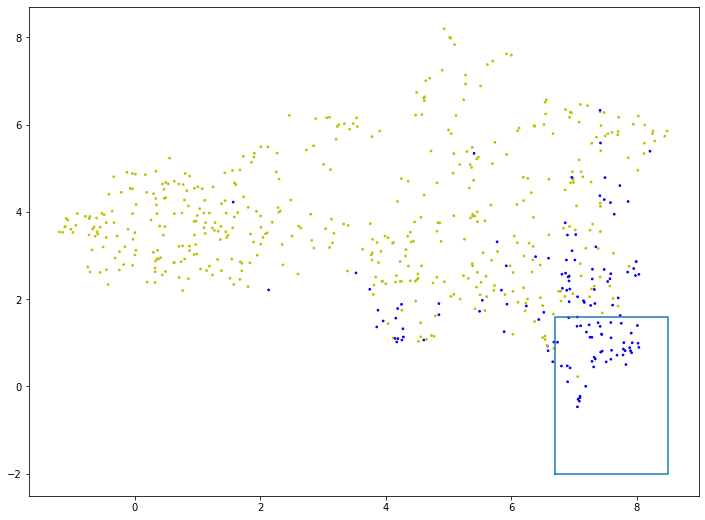

In [235]:
# Display manual clustering of the UMAP embedding
# 0 - haze
# 1 - primary
# 2 - agriculture
# 3 - clear
# 4 - water
# 5 - habitation
# 6 - road
# 9 - cloudy
# 10 - partly_cloudy

label_id = 6
no_samples = 600

coords = umap_InceptionV3_coords[label_id]
poly = Polygon(coords)

color = []
#for i in range(len(y_train)):
for i in range(no_samples):
    if y_train[i,label_id] == 1:
        color.append('b') #
    else:
        color.append('y') #other

plt.figure(figsize=(12,9))
#plt.scatter(umap_bigearthnet[:, 0], umap_bigearthnet[:, 1], c=color, s=0.1, cmap='Scatter')
plt.scatter(umap_InceptionV3[:no_samples, 0], umap_InceptionV3[:no_samples, 1], c=color, s=3, cmap='Scatter')
plt.plot(*poly.exterior.xy)

In [163]:
def haze_bigearthnet_umap(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(umap_bigearthnet[i, 0], umap_bigearthnet[i, 1])
    coord = umap_bigearthnet_coords[HAZE_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [164]:
evaluate_LF(haze_bigearthnet_umap, labels_df_test, 'haze', full_dataset = False)

TP:  5
FP:  60
TN:  869
FN:  66
abstain:  0
accuracy:  0.874
precision:  0.07692307692307693
coverage:  1.0


In [153]:
def primary_bigearthnet_umap(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(umap_bigearthnet[i, 0], umap_bigearthnet[i, 1])
    coord = umap_bigearthnet_coords[PRIMARY_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [154]:
evaluate_LF(primary_bigearthnet_umap, labels_df_test, 'primary', full_dataset = False)

TP:  841
FP:  72
TN:  7
FN:  80
abstain:  0
accuracy:  0.848
precision:  0.9211391018619934
coverage:  1.0


In [178]:
def agriculture_bigearthnet_umap(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(umap_bigearthnet[i, 0], umap_bigearthnet[i, 1])
    coord = umap_bigearthnet_coords[AGRICULTURE_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [179]:
evaluate_LF(agriculture_bigearthnet_umap, labels_df_test, 'agriculture', full_dataset = False)

TP:  105
FP:  217
TN:  481
FN:  197
abstain:  0
accuracy:  0.586
precision:  0.32608695652173914
coverage:  1.0


In [187]:
def water_bigearthnet_umap(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(umap_bigearthnet[i, 0], umap_bigearthnet[i, 1])
    coord = umap_bigearthnet_coords[WATER_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [188]:
evaluate_LF(water_bigearthnet_umap, labels_df_test, 'water', full_dataset = False)

TP:  60
FP:  300
TN:  535
FN:  105
abstain:  0
accuracy:  0.595
precision:  0.16666666666666666
coverage:  1.0


In [214]:
def water_InceptionV3_umap(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(umap_InceptionV3[i, 0], umap_InceptionV3[i, 1])
    coord = umap_InceptionV3_coords[WATER_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [215]:
evaluate_LF(water_InceptionV3_umap, labels_df_test, 'water', full_dataset = False)

TP:  6
FP:  30
TN:  788
FN:  176
abstain:  0
accuracy:  0.794
precision:  0.16666666666666666
coverage:  1.0


In [236]:
def road_InceptionV3_umap(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(umap_InceptionV3[i, 0], umap_InceptionV3[i, 1])
    coord = umap_InceptionV3_coords[ROAD_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [237]:
evaluate_LF(road_InceptionV3_umap, labels_df_test, 'road', full_dataset = False)

TP:  20
FP:  68
TN:  742
FN:  170
abstain:  0
accuracy:  0.762
precision:  0.22727272727272727
coverage:  1.0
